# Statistical Approaches to Neuroscience

Theoretical quantities describe a probability distribution. Estimates of theoretical quantities from data are noisy and we must quantify the accuracy of our estimate.

To warm up, let's consider a particular probability distribution- the standard normal with mean   and standard deviation . The corresponding probability density function (pdf) is

$$p(x|\mu=0, \sigma=1)=\frac{1}{\sqrt{2\pi}}exp(\frac{-x^2}{2})$$
 
which is the familiar "bell curve," pictured below

In [1]:
import sys
sys.path.append('../src/')
import opencourse as oc

In [2]:
import numpy as np
import scipy.stats as stt
import matplotlib.pyplot as plt
import pandas as pd
from scipy import polyfit
from scipy.ndimage.filters import gaussian_filter1d
%matplotlib inline

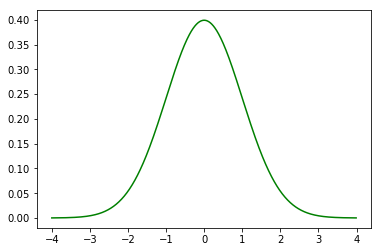

In [4]:
# Below we'll plot the PDF of a normal distribution.
mean, std = 0, 1
inputs = np.arange(-4, 4, .01)
prob = stt.norm.pdf(inputs, mean, std)

fig, ax = plt.subplots()
ax.plot(inputs, prob, 'g')

Take and $\beta_0=3$ and $\beta_1=5$, then we can generate a dataset from our statistical model, such as the one pictured below. In black we plot the line $y=3+5x$, and in red we plot the line of best fit, in the least squares sense.

In [5]:
def simulate_data(n_datapoints, beta_1, beta_0, noise_func=np.random.randn):
    x = np.random.rand(n_datapoints)
    noise = noise_func(n_datapoints)
    y = beta_1 * x + beta_0 + noise
    return x, y

def fit_model_to_data(x, y, model_degree=1):
    betas_hat = polyfit(x, y, model_degree)
    return betas_hat

In [6]:
n_datapoints = 25
beta_1 = 5
beta_0 = 3
x, y = simulate_data(n_datapoints, beta_1, beta_0)
beta_1_hat, beta_0_hat = fit_model_to_data(x, y)

In [7]:
# Create "test" predicted points for our two models
x_pred = np.linspace(x.min(), x.max(), 1000)

# The "true" model
y_pred_true = x_pred * beta_1 + beta_0
y_pred_model = x_pred * beta_1_hat + beta_0_hat

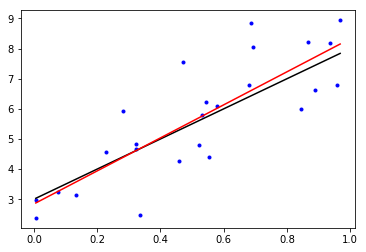

In [8]:
# Now plot the sample datapoints and our model
fig, ax = plt.subplots()
ax.plot(x, y, 'b.')
ax.plot(x_pred, y_pred_true, 'k')
ax.plot(x_pred, y_pred_model, 'r')

Of course, the red and the black lines are not identical, because our datapoints are a random sample from our statistical model. If we were to resample our data, we would get an entirely different set of datapoints, and consequently a new set of estimates.

In fact, let's see this in action, and quantify the variability of our least squares estimate of the slope of the line. Let's sample multiple datasets from our model, and for each dataset estimate the slope of the least squares line. We can then plot a histogram of our estimated slopes. Again, the procedure is:

1. Generate multiple datasets from our known statistical model
2. Calculate the statistic of interest for each dataset (here, the slope), and collect them into a vector (say
slopeStar)
3. Estimate the SE by calculating the standard deviation of the entries of slopeStar.

In [9]:
n_datapoints = 25
n_simulations = 1000
beta_1 = 5
beta_0 = 3

betas = np.zeros([n_simulations, 2])
simulations = np.zeros([n_simulations, x_pred.shape[-1]])
for ii in range(n_simulations):
    x = np.random.rand(n_datapoints)
    noise = np.random.randn(n_datapoints)
    y = beta_1 * x + beta_0 + noise

    beta_1_hat, beta_0_hat = polyfit(x, y, 1)
    y_pred_model = x_pred * beta_1_hat + beta_0_hat
    betas[ii] = [beta_0_hat, beta_1_hat]
    simulations[ii] = y_pred_model

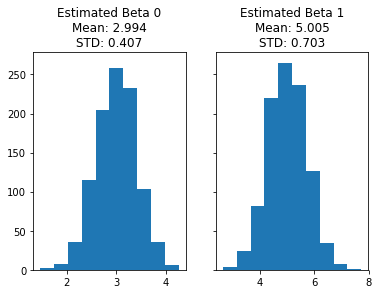

In [10]:
fig, axs = plt.subplots(1, 2, sharey=True)
for ii, (ax, ibeta) in enumerate(zip(axs, betas.T)):
    ax.hist(ibeta)
    ax.set_title("Estimated Beta {}\nMean: {:.3f}\nSTD: {:.3f}".format(
            ii, ibeta.mean(), ibeta.std()))

Here we see that the estimates for the slope of the least squares line have a histogram that looks like
it could have plausibly been generated from a normal distribution, centered around the true slope. The histogram also yields an estimate of the standard error of the slope estimates. While in this simple case we could have easily derived the standard error theoretically, it is very easy to do so through simulation. Further, there are some instances where the standard error is diffucult to come by theoretically, and so simulation is a critical tool.

> QUESTION: What happens as sample size increases or decreases (e.g. sizeDataSet=15, 100, 250, 500, 1000)? . What happens if the errors are not normally distributed?


> ADVANCED QUESTION: What happens to the variability of the empirical mean as the number of simulated datasets (numberDataSets) increases?

In [11]:
def simulate_multiple_data_sets(beta_1, beta_0, sample_sizes,
                                noise_func=np.random.randn, n_simulations=1000,
                                n_col=2):
    
    n_row = int(np.ceil(len(sample_sizes) / float(n_col)))
    fig, axs = plt.subplots(n_row, n_col, figsize=(3*n_col, 3*n_row), sharex=True)
    for n_samples, ax in zip(sample_sizes, axs.ravel()):
        all_betas = np.zeros([n_simulations, 2])
        for ii in range(n_simulations):
            x, y = simulate_data(n_samples, beta_1, beta_0, noise_func=noise_func)
            betas = fit_model_to_data(x, y)
            all_betas[ii] = betas
        ax.hist(all_betas[:, 0])
        ax.set_title('Sample size: {}'.format(n_samples))
    _ = fig.suptitle(r'Distribution of $\beta_1$', fontsize=20)
    return fig

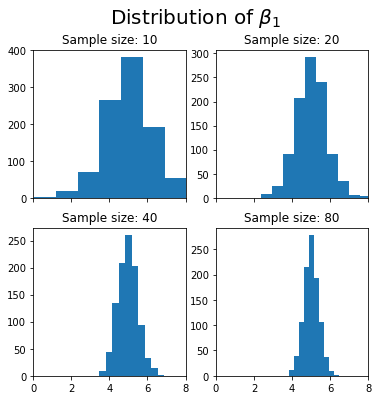

In [12]:
### QUESTION ANSWER
sample_sizes = [10, 20, 40, 80]
n_simulations = 1000
fig = simulate_multiple_data_sets(beta_1, beta_0, sample_sizes)
_ = plt.setp(fig.axes, xlim=[0, 8])

(array([ 21.,   9.,  18.,   9.,   7.,   7.,   7.,   7.,   3.,   2.,   2.,
          2.,   0.,   4.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.8588648 , -0.66376143, -0.46865806, -0.27355469, -0.07845132,
         0.11665205,  0.31175542,  0.50685879,  0.70196216,  0.89706553,
         1.0921689 ,  1.28727227,  1.48237564,  1.67747901,  1.87258238,
         2.06768574,  2.26278911,  2.45789248,  2.65299585,  2.84809922,
         3.04320259]),
 <a list of 20 Patch objects>)

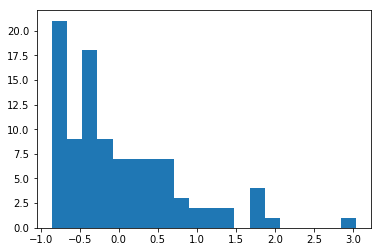

In [13]:
### QUESTION ANSWER
def my_noise_func(n):
    noise = 4 * np.random.beta(1, 3, n)
    return noise - np.mean(noise)
fig, ax = plt.subplots()
ax.hist(my_noise_func(100), bins=20)

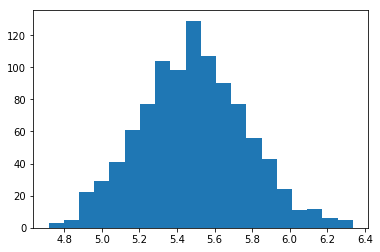

In [14]:
### QUESTION ANSWER
# Effect of different noise distributions on the empirical mean
# Define noise function here
empirical_means = np.zeros(n_simulations)

# Run simulations
for ii in range(n_simulations):
    x, y = simulate_data(n_datapoints, beta_1, beta_0, noise_func=my_noise_func)
    empirical_means[ii] = np.mean(y)
    
# Plot the results
fig, ax = plt.subplots()
_ = ax.hist(empirical_means, bins=20)

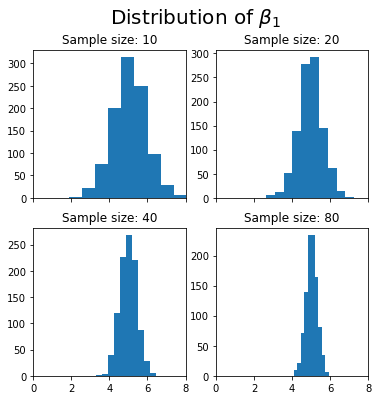

In [15]:
### QUESTION ANSWER
# Fit multiple datasets and show how error dist changes betas
fig = simulate_multiple_data_sets(beta_1, beta_0, sample_sizes,
                                  noise_func=my_noise_func)
_ = plt.setp(fig.axes, xlim=[0, 8])

So far we have used simulation to show that estimates of statistics of interest are inherently variable across datasets. In practice, however, we only collect one dataset, but we still want to quantify the variability of our estimate. It turns out that the simulation procedure from above is still useful to us.

## The bootstrap helps us to quantify the SE for a statistic of interest.

In the section above we empirically showed the validity of some theoretical claims, though we relied on both knowlege of the probability distribution- and knowlege of its parameters- in order to generate multiple datasets. In practice, we may be willing to assume that a certain probability distribution could have reasonably generated our data, though we certainly don't know the true parameters of that distribution. In order to understand the variability of an estimate of a statistic, however, we can still use the framework developed above. Specifically our new procedure, the **parametric bootstrap**, is

1. Estimate the parameters of the assumed probability distribution using our dataset and the maximum likelihood estimation procedure.
2. Generate multiple datasets (pseudo-data) from the assumed distribution, plugging in the parameter estimates in place of their theoretical quantities.
3. Calculate the statistic of interest for each dataset, and collect them in a vector (say tStar)
4. Estimate the SE by calculating the standard deviation of the entries of tStar.

##  The nonparametric bootstrap helps us to quantify the SE for a statistic of interest when our distribution is unknown or highly complex.

The general procedure for the nonparametric bootstrap is essentially the same as before. The steps are

1. Generate multiple datasets (pseudo-data)
2. Calculate the statistic of interest for each dataset and collect the statistics 3. Estimate the SE by calculating the standard deviation of the statistics.

The only question that remains is how to generate our pseudo-data. We do this by bootstrap sampling (or sampling with replacement) from our actual dataset.

Let's practice the nonparametric bootstrap with a PSTH. Here our dataset consists of stimulus-locked trials, where each trial is represented by a vector with entries representing the number of spikes in the
respective 50ms bin. Let be the vector of spike counts for the trial, then we can calculate the PSTH as

$$PSTH=\frac{\sum{x_i}}{N*.05}$$

where N is the total number of trials.

> TASK: From the StevensonV2 dataset, plot the smoothed PSTH for neuron 193 and target location [0.0706 -0.0709]. Provide 95% confidence bands for the PSTH obtained through the nonparametric bootstrap. Finally, from the smoothed PSTH, estimate the location of the maximal firing rate in the PSTH. From your bootstrapped samples, obtain the bootstrapped distribution of the maximal firing rate.

The bootstrap procedure is:

1. Generate multiple (say, 1000) datasets (pseudo-data) by obtaining a bootstrap sample from the original dataset
2. Calculate the statistic of interest for each dataset (here it will be the smoothed PSTH)
3. In the simulation above we stored the statistic of interest (the mean) for each dataset in a vector called
meanStar. In this case, each psuedo-dataset will generate a PSTH, which we will store as a row vector
in a matrix called psthStar.
4. Smooth each bootstrapped PSTH. For now, we can simply smooth each PSTH with a Gaussian filter.
Set the window witdth to 5.
5. To obtain the 95% confidence interval we can sort each column independently and record the 25th and
975th entries for each column (assuming we are generating 1000 bootsrapped datasets). Plot these
confidence bands.
6. Calculate the location of the maximal firing rate for each bootstrapped dataset.
7. Plot the distribution of maximal firing rate locations.

For your convenience, a dataset for neuron 193 and target location [0.0706 -0.0709] is generated in the code below. To play around with a different neuron or location, simply change the variables "neuron" and "targetInterest". The variable you will use from this section is "trialMat" which collects the trials along the rows.

In [17]:
from scipy import io as si
data = si.loadmat('../data/StevensonV2.mat')

In [18]:
# This defines the neuron and target locations we care about
neuron_n = 192
target_location = [0.0706, -0.0709]

In [19]:
# Extract useful information from our dataset
all_spikes = data['spikes']
spikes = all_spikes[neuron_n]
time = data['time']

# This is the onset of each trial
onsets = data['startBins'][0]

# This determines where the target was on each trial
locations = data['targets']
locations = locations.T[:, :2]
unique_locations = np.unique(locations)
n_trials = onsets.shape[0]

In [20]:
# Define time and the sampling frequency of data
time_step = data['timeBase']
sfreq = (1. / time_step).squeeze()

In [21]:
# Define trials with the target location
diff = (locations - target_location) < 1e-4
mask_use = diff.all(axis=1)

In [22]:
# Low-pass the spikes to smooth
spikes_low = gaussian_filter1d(spikes.astype(float),5)

Now that we have information about when each trial begins, we can slice our data so that we collect a window around each trial. Here we'll define the window, and create a new array of shape (trials, neurons, times). We'll use the phrase `epochs` interchangeably with `trials`.

In [23]:
# Convert data into epochs
wmin, wmax = -5., 15.
epochs = []
for i_onset in onsets[mask_use]:
    this_spikes = spikes_low[i_onset + int(wmin): i_onset + int(wmax)]
    epochs.append(this_spikes)
epochs = np.array(epochs)
n_ep = len(epochs)

In [24]:
# Define time for our epochs
tmin = wmin / sfreq
tmax = wmax / sfreq
times = np.linspace(tmin, tmax, num=epochs.shape[-1])

We'll now bootstrap lower / upper bounds for the activity at each timepoint in a trial. We'll do this by considering the data across trials.

In [25]:
# Bootstrap lo / hi at each time point
n_boots = 1000
boot_means = np.zeros([n_boots, len(times)])
for ii, i_time in enumerate(times):
    for jj in range(n_boots):
        sample = epochs[:, ii][np.random.randint(0, n_ep, n_ep)]
        boot_means[jj, ii] = sample.mean()
max_times = boot_means.argmax(axis=1)
clo, chi = np.percentile(boot_means, [2.5, 97.5], axis=0)

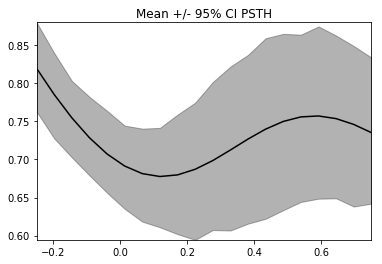

In [26]:
# Plot the mean firing rate across trials
fig, ax = plt.subplots()
ax.plot(times, epochs.mean(0), 'k')
ax.fill_between(times, clo, chi, alpha=.3, color='k')
ax.set_title('Mean +/- 95% CI PSTH')
plt.autoscale(tight=True)

Finally, we can plot the timepoint that had the most activity in each bootstrap iteration. This gives us an idea for the variability across trials, and where in time the activity tends to be clustered.

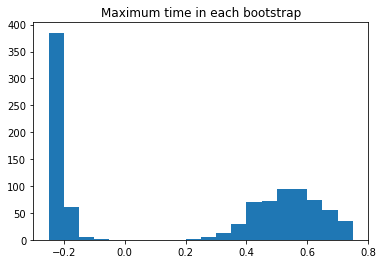

In [27]:
fig, ax = plt.subplots()
_ = ax.hist(times[max_times], bins=20)
ax.set_title('Maximum time in each bootstrap')

---
> ADVANCED QUESTION:
   
> Question: What happens to a bootstrapped estimate of the standard error (as compared to the theoretically derived standard error) as the sample size (not the number of bootstrapped datasets) increases? You can test your answer as follows:
1. Sample a dataset of some sample size from a known distribution (say, a normal distribution)
2. For several different sample sizes ( say, sizeDataSet=15, 50, 100, 150, 300, 500, 1000, 10000,
100000), and for some statistic (for instance the mean), do the following:
  * Calculate the theoretical SE for the given sample size (you can also calculate this by simulation as we did above, though keep this simulation distinct from your original dataset)
  * Perform a nonparametric bootstrap on your original dataset
  * Compare the bootstrap SE and the theoretical SE.
---

In [28]:
### QUESTION ANSWER
sample_sizes = [15, 50, 100, 150, 300, 500, 1000, 10000]
n_simulations = 1000
stat = np.mean
random_func = np.random.randn

#
standard_errors = pd.DataFrame(index=sample_sizes,
                               columns=['se', 'se_bootstrap'])
for n_sample in sample_sizes:
    sample = random_func(n_sample)
    se = np.std(sample) / np.sqrt(n_sample)

    simulation_means = np.zeros(n_simulations)
    for ii in range(n_simulations):
        boot_sample = sample[np.random.randint(0, n_sample, n_sample)]
        simulation_means[ii] = stat(boot_sample)
    se_boot = np.std(simulation_means)
    standard_errors.loc[n_sample] = [se, se_boot]

standard_errors

,se,se_bootstrap
15,0.265862,0.262204
50,0.14491,0.146257
100,0.0923554,0.0971845
150,0.0898804,0.0935635
300,0.0598759,0.0590615
500,0.0464491,0.0475657
1000,0.0312865,0.0313367
10000,0.0100287,0.0100186


As you can see, there is a strong correlation between the bootstrapped standard error, and the theoretical standard error. This won't always be the case, especially when data are not normally distributed.